Content warning: the Perspective API is designed for use in content moderation, and the dataset contained very “toxic” comments. Some of the comments in this dataset are racist, sexist, ableist, and offensive. Some comments contain profane language. The particular analysis in the dataset is of high scoring and thus comments considered toxic.

This is a notebook for the exploration, bias testing, and analysis of the Perspective API.

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
import time
from tqdm import tqdm

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\micha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Done importing.

In [3]:
comments_df = pd.read_csv('labeled_and_scored_comments.csv')
comments_df.head()

,id,comment_text,score,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0001ea8717f6de06,Thank you for understanding. I think very high...,0.075638,0,0,0,0,0,0
1,000247e83dcc1211,:Dear god this site is horrible.,0.450459,0,0,0,0,0,0
2,0002f87b16116a7f,"""::: Somebody will invariably try to add Relig...",0.667964,0,0,0,0,0,0
3,0003e1cccfd5a40a,""" \n\n It says it right there that it IS a typ...",0.068434,0,0,0,0,0,0
4,00059ace3e3e9a53,""" \n\n == Before adding a new product to the l...",0.151724,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
41333,9480bff99f91a69e,Lesbian Teenager \nHow about the fact she was ...,0.797672,1,0,0,0,0,0
41334,9480115b93762c35,"Crack, also called cocaine is very good for yo...",0.240977,0,0,0,0,0,0
41335,947f206c14a85d9d,REDIRECT Talk:The Test (The O.C.),0.012671,0,0,0,0,0,0
41336,947e3f5f2d613605,A question concerning your edit to my user-pag...,0.227474,0,0,0,0,0,0


Exploring the dataset:

<AxesSubplot:>

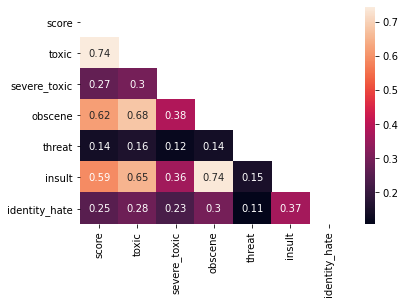

In [11]:
#Selecting all columns besides the text and id
corr_df = comments_df.iloc[:, 2:9]
corr = corr_df.corr()

matrix = np.triu(corr)
sns.heatmap(corr, annot=True, mask=matrix)

Interesting relationships to consider testing:
- Score's relationship with tags: seems to make intuitive sense since a higher score and thus toxic comment should have more tags.
- Toxic and obscene/insult tags: also makes intuitive sense because toxic comments are likely to also be tagged as those tags.
- Why does the threat tag have so little correlation with the other tags? Is it because of sample size?

Next, going to parse through the text for the most common words used in each tag.

In [14]:
for col in corr_df.columns:
    print(corr_df[col].value_counts())

0.310894    476
0.515460    163
0.534903    144
0.695427    141
0.860626    141
           ... 
0.083869      1
0.325597      1
0.098854      1
0.271365      1
0.209748      1
Name: score, Length: 39108, dtype: int64
0    37395
1     3943
Name: toxic, dtype: int64
0    40959
1      379
Name: severe_toxic, dtype: int64
0    39145
1     2193
Name: obscene, dtype: int64
0    41213
1      125
Name: threat, dtype: int64
0    39279
1     2059
Name: insult, dtype: int64
0    40936
1      402
Name: identity_hate, dtype: int64


The toxic, obscene, and insult tag seem to have the most messages labeled as so. This also can explain part of the reason as to the threat tag has so little correlation with the rest of the values: there are only 125 entries labeled as so. 

In [24]:
count_df = comments_df[['comment_text', 'score', 'toxic', 'obscene', 'insult']]

#Removing stopwords
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text)
    
    new_comment = []
    for word in word_tokens:
        if word not in stop_words:
            new_comment.append(word)
    
    return(" ".join(new_comment))

cleaned_text = []
for comment in tqdm(count_df['comment_text']):
    cleaned_comment = remove_stopwords(comment)
    cleaned_text.append(cleaned_comment)

count_df['comment_text'] = cleaned_text
count_df

100%|██████████| 41338/41338 [00:29<00:00, 1397.78it/s]
C:\Users\micha\AppData\Local\Temp\ipykernel_6856\2868675213.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  count_df['comment_text'] = cleaned_text


,comment_text,score,toxic,obscene,insult
0,Thank understanding . I think highly would rev...,0.075638,0,0,0
1,: Dear god site horrible .,0.450459,0,0,0
2,`` : : : Somebody invariably try add Religion ...,0.667964,0,0,0
3,`` It says right IS type . The `` '' Type '' '...,0.068434,0,0,0
4,"`` == Before adding new product list , make su...",0.151724,0,0,0
...,...,...,...,...,...
41333,Lesbian Teenager How fact lesbian teenaged yea...,0.797672,1,0,0
41334,"Crack , also called cocaine good , say young t...",0.240977,0,0,0
41335,REDIRECT Talk : The Test ( The O.C . ),0.012671,0,0,0
41336,A question concerning edit user-page I 'm afra...,0.227474,0,0,0


Now that the text has been cleaned, to find the words used in each particular tag, dictionaries will be created. There will also be a dictionary created for comments with high score. In this case, the threshold for a high score will be a comment with a score of >0.5.

In [43]:
#Creating dictionaries of the words used.

def getDict(df, column):
    count_dict = {}
    if column == 'score':
        for comment in df[df[column] > 0.5]['comment_text']:
            commentList = comment.split()
            for word in commentList:
                if word in count_dict:
                    count_dict[word] += 1
                else:
                    count_dict[word] = 1
    else:
        for comment in df[df[column] == 1]['comment_text']:
            commentList = comment.split()
            for word in commentList:
                if word in count_dict:
                    count_dict[word] += 1
                else:
                    count_dict[word] = 1
            
    sorted_dict = sorted(count_dict.items(), key=lambda x: x[1], reverse=True)
    return sorted_dict

toxic_dict = getDict(count_df, 'toxic')
obscene_dict = getDict(count_df, 'obscene')
insult_dict = getDict(count_df, 'insult')
score_dict = getDict(count_df, 'score')

score_dict[:50]

[('!', 19271),
 ('.', 17547),
 (',', 15934),
 ("''", 8869),
 ('I', 8764),
 ('``', 5091),
 ('?', 3942),
 (':', 2650),
 ("n't", 2644),
 ('YOU', 2571),
 ("'s", 2489),
 ('You', 2299),
 (')', 2131),
 ('FUCK', 1951),
 ('(', 1876),
 ('like', 1361),
 ('fuck', 1328),
 ('==', 1192),
 ('page', 1068),
 ('A', 1028),
 ('article', 992),
 ('The', 976),
 ('people', 969),
 ('know', 963),
 ('*', 901),
 ('...', 893),
 ('-', 845),
 ('Wikipedia', 837),
 ('get', 811),
 ('one', 801),
 ('ALL', 794),
 ("'m", 782),
 ("'re", 773),
 ('It', 752),
 ('would', 746),
 ('AIDS', 746),
 ('Nipple', 709),
 ("'", 685),
 ('stupid', 683),
 ('MY', 654),
 ('think', 647),
 ('fucksex', 624),
 ('sucks', 621),
 ('teabag', 620),
 ('hate', 616),
 ('OF', 600),
 ('ARE', 581),
 ('FREEDOM', 575),
 ('want', 569),
 ('time', 567)]

A brief inspection of the dictionaries reveals that there are some similarities between them. For example, although there is punctuation and single letters sneaking into the top, words that seem to be consistently tagged are "fuck" and "you". Although the word "you" doesn't carry any negative sentiment by itself, it is likely often used in conjunction with "fuck". This indicates that the Perspective API considers how words in context, which makes it more tuned to natural human speech. 

However, the `score_dict` also has some seemingly neutral words. This is likely because of the threshold set for the score in the dictionary creation: only comments that had a score of >0.5 were selected. This indicates that around that score threshold, the automatic scoring of Perspective may be making errors when considering some comments to have higher polarity than they truly do.

To test for bias, the Perspective API will be queried for words in `toxic_dict` and `score_dict` to see if they carry a similar amount of polarity. 

A brief hypothesis: individual intuitively neutral words will return low scores, even if they appear frequently in the the dictionaries for words that are labeled toxic. Curse words will still yield a high toxcicity score. Neutral words used with curse words will still yield a high score, because the Perspective API seems to be trained off of context and n-grams rather than individual words. To test this, set of words and phrases will be created out of the `score_dict` and `toxic_dict`.

As a note, the toxicity that the query returns may not be consistent with the labeling for several reasons. There may indeed be bias, or there might be additional context within the word being queried missed that makes it appear frequently in comments labeled as toxic.


The following code segments for querying the API are from the class template.

In [37]:
from googleapiclient.discovery import build
import json

def get_toxicity_score(comment):
    
  API_KEY = '' # Put your API key here
    
  client = build(
  "commentanalyzer",
  "v1alpha1",
  developerKey=API_KEY,
  discoveryServiceUrl="https://commentanalyzer.googleapis.com/$discovery/rest?version=v1alpha1",
  static_discovery=False,
  )

  analyze_request = {
  'comment': { 'text': comment },
  'requestedAttributes': {'TOXICITY': {}}
  }
    
  response = client.comments().analyze(body=analyze_request).execute()
  toxicity_score = response["attributeScores"]["TOXICITY"]["summaryScore"]["value"]
    
  return toxicity_score

In [38]:
get_toxicity_score("article")

0.0723261

In [44]:
query_list = ['article', 'You', 'The people know', 'authority', 'follow authority', 'metal', 'nonsense','homosexual', 'fuck', 'fuck you', 'like', 'page', 'jerk', 'stupid', 'dumb']
for comment in query_list:
    score = get_toxicity_score(comment)
    print(comment, score)
    time.sleep(1)

article 0.07232613
You 0.079551965
The people know 0.06121505
authority 0.04766297
follow authority 0.025004705
metal 0.09158879
nonsense 0.3465714
homosexual 0.64240694
fuck 0.9671429
fuck you 0.9897058
like 0.02861636
page 0.07765976
jerk 0.9217174
stupid 0.9147037
dumb 0.8454821


### Analysis

The tested words contain some neutral words and phrases as well as some profanity and more polarizing language. Individual curse words still yielded a high score, as expected. Individually neutral words yielded a low score, but when they were used with curse words in phrases, they returned a high score. This informs an understanding of the Perspective API because it indicates how the training considers the message as a whole rather than just looking at each individual word's sentiment.

A particularly interesting query is the "article" query. It returns a very low score, but it is one of the most used words in the dictionary with comments of scores over >0.5. This indicates that the word "article" is often used with toxic words, which drives its appearances with high score comments up even if the word itself is rather neutral. This makes intuitive sense in terms of the Perspective API. Because it is looking at Wikipedia articles, phrases such as "dumb article" will indicate toxicity particularly because the word dumb pushes the score for the phrase up.

A potential source of bias within the labeling of the articles can be seen with the discussion of sample size previously. Although many comments may fit into multiple categories of toxic/obscene/insult, the labeling seems to be most common in particular categories. Furthermore, the `severe_toxic` column is even more subjective than the rest of the column names, because it is up to a certain amount of discretion as to whether a toxic comment crosses the threshold into severely toxic. 

Another interesting discussion can be where words are labeled toxic even though they are not considered profanity. For example, the word "homosexual" has a relatively high score even though it is not in and of itself a toxic word. Rather, it becomes considered toxic through Perspective learning that the word "homosexual" is being used as an insult. This indicates that Perspective is able to identify whether ot not particular words are being used in a toxic manner, even if their base sentiment is not initially toxic. Again, this fits into the initial theory that the natural language processing used within Perspective considers the full context surrounding a particular word or phrase. 

Further research may involve how the perspective toxicity compares to other forms of sentiment analysis (i.e. the NLTK word net and VADER analyzer). Analysis can be done on discrepancies behind the polarity in other sentiment analysis in comparison to Perspective's. 